# Beyond Model Linearity

The truth is never linear!
Or almost never!
But often the linearity assumption is good enough.
When its not :
- polynomials, ($y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\beta_{3} x_{i}^{3}+\ldots+\beta_{d} x_{i}^{d}+\epsilon_{i}$)
- step functions,
- splines,
- local regression, and
- generalized additive models
offer a lot of 
flexibility, without losing the ease and
interpretability of linear models.

In [ ]:
import pandas as pd
import pandas.util.testing as tm
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from patsy import dmatrix

import re

%matplotlib inline
plt.style.use('seaborn-white')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [ ]:
df_wage = pd.read_csv('https://raw.githubusercontent.com/nikbearbrown/Google_Colab/master/data/wage.csv')
df_wage.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
for col_name in df_wage.columns:
    if df_wage[col_name].dtype == 'object':
        # get list of categories
        cat_list = np.sort(df_wage[col_name].unique())
        # create a categorical dtype that is ordered for the columns that makes sense
        cat_dtype = CategoricalDtype(cat_list, ordered=True if col_name in ['education', 'health'] else False)        
        df_wage[col_name] = df_wage[col_name].astype(cat_dtype)
        # strip '#. ' from the categories names
        df_wage[col_name].cat.categories  = [re.sub(r"\d+.\s+", "", cat) for cat in cat_list]
        print(f'{col_name}: {df_wage[col_name].cat.categories.values}')
df_wage.head(3)

sex: ['Male']
maritl: ['Never Married' 'Married' 'Widowed' 'Divorced' 'Separated']
race: ['White' 'Black' 'Asian' 'Other']
education: ['< HS Grad' 'HS Grad' 'Some College' 'College Grad' 'Advanced Degree']
region: ['Middle Atlantic']
jobclass: ['Industrial' 'Information']
health: ['<=Good' '>=Very Good']
health_ins: ['Yes' 'No']


,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,Male,Never Married,White,< HS Grad,Middle Atlantic,Industrial,<=Good,No,4.318063,75.043154
1,2004,24,Male,Never Married,White,College Grad,Middle Atlantic,Information,>=Very Good,No,4.255273,70.476020
2,2003,45,Male,Married,White,Some College,Middle Atlantic,Industrial,<=Good,Yes,4.875061,130.982177


In [ ]:
df_wage.describe(include='category')

,sex,maritl,race,education,region,jobclass,health,health_ins
count,3000,3000,3000,3000,3000,3000,3000,3000
unique,1,5,4,5,1,2,2,2
top,Male,Married,White,HS Grad,Middle Atlantic,Industrial,>=Very Good,Yes
freq,3000,2074,2480,971,3000,1544,2142,2083


### Polynomial Regresssion

$y_{i}=\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\beta_{3} x_{i}^{3}+\ldots+\beta_{d} x_{i}^{d}+\epsilon_{i}$

In [ ]:
# polynomial regression
linear = skl_lm.LinearRegression()
poly = PolynomialFeatures(4)

X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']

X_poly = poly.fit_transform(X)
linear.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# logistic regression
df_logistic_wage = pd.DataFrame({'age': df_wage['age'].values, 'large_wage': df_wage['wage'].values > 250}, 
                                columns=['age', 'large_wage'])
df_logistic_wage.large_wage = df_logistic_wage.large_wage.astype(int)

X = df_logistic_wage['age'].values.reshape(-1, 1).astype(float)
y = df_logistic_wage['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('polynomial', PolynomialFeatures(4)),
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=4, include_bias=True,
                                    interaction_only=False, order='C')),
                ('logistic',
                 LogisticRegression(C=10000000000.0, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

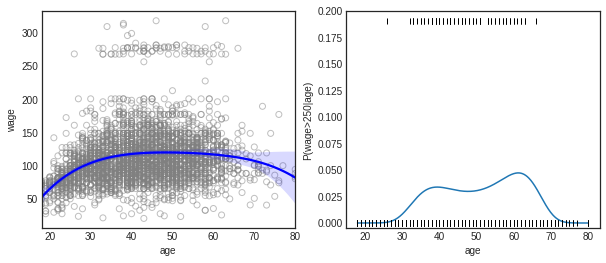

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_wage.age, df_wage.wage, facecolors='None', edgecolors='grey', alpha=.5)
# seaborn uses np.polyfit to fit a polynomial of order 4 to the data, basically the same we did with sklearn
sns.regplot(df_wage.age, df_wage.wage, ci=100, label='Degree 4', order=4, scatter=False, color='blue', ax=ax1)

age_range = np.linspace(df_logistic_wage.age.min(), df_logistic_wage.age.max(), 1000).reshape((-1, 1))
# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(X, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

Details
- Create new variables $X_{1}=X, X_{2}=X^{2},$ etc and then treat as multiple linear regression.
- Not really interested in the coefficients; more interested in the fitted function values at any value $x_{0}:$
$$
\hat{f}\left(x_{0}\right)=\hat{\beta}_{0}+\hat{\beta}_{1} x_{0}+\hat{\beta}_{2} x_{0}^{2}+\hat{\beta}_{3} x_{0}^{3}+\hat{\beta}_{4} x_{0}^{4}
$$
- Since $\hat{f}\left(x_{0}\right)$ is a linear function of the $\hat{\beta}_{\ell},$ can get a simple expression for pointwise-variances $\operatorname{Var}\left[\hat{f}\left(x_{0}\right)\right]$ at any value $x_{0} .$ In the figure we have computed the fit and pointwise standard errors on a grid of values for $x_{0} .$ We show $\hat{f}\left(x_{0}\right) \pm 2 \cdot \operatorname{se}\left[\hat{f}\left(x_{0}\right)\right]$
- We either fix the degree $d$ at some reasonably low value, else use cross-validation to choose $d$
- Logistic regression follows naturally. For example, in figure we model
$$
\operatorname{Pr}\left(y_{i}>250 | x_{i}\right)=\frac{\exp \left(\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\ldots+\beta_{d} x_{i}^{d}\right)}{1+\exp \left(\beta_{0}+\beta_{1} x_{i}+\beta_{2} x_{i}^{2}+\ldots+\beta_{d} x_{i}^{d}\right)}
$$
- To get confidence intervals, compute upper and lower bounds on on the logit scale, and then invert to get on probability scale.
- Can do separately on several variables- just stack the variables into one matrix, and separate out the pieces afterwards (see GAMs later).
- Caveat: polynomials have notorious tail behavior - very bad for extrapolation.
- Can fit using $\mathrm{y} \sim \operatorname{poly}(\mathrm{x}, \text { degree }=3)$ in formula.

### Step Function
Another way of creating transformations of a variable - cut the variable into distinct regions. $C_{1}(X)=I(X<35), \quad C_{2}(X)=I(35 \leq X<50), \ldots, C_{3}(X)=I(X \geq 65)$

In [ ]:
# fit a stepwise function to wage data. Use four bins like in Figure 7.2
num_bins = 4

df_step = pd.DataFrame(pd.cut(df_wage.age, num_bins))
df_step = pd.get_dummies(df_step)
df_step['wage'] = df_wage.wage
df_step['age'] = df_wage.age
df_step.head(3)

,"age_(17.938, 33.5]","age_(33.5, 49.0]","age_(49.0, 64.5]","age_(64.5, 80.0]",wage,age
0,1,0,0,0,75.043154,18
1,1,0,0,0,70.476020,24
2,0,1,0,0,130.982177,45


In [ ]:
# linear regression
linear = skl_lm.LinearRegression()

X = df_step[df_step.columns.difference(['wage', 'age'])]
y = df_step['wage']

linear.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# logistic regression
df_logistic_step = df_step.copy()
df_logistic_step['large_wage'] = (df_logistic_step['wage'].values > 250).astype(int)

X = df_logistic_step[df_step.columns.difference(['wage', 'age', 'large_wage'])]
y = df_logistic_step['large_wage']

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('logistic', skl_lm.LogisticRegression(C=1e10))])
# Fit all the transforms one after the other and transform the data, then fit the transformed data using the final estimator.
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic',
                 LogisticRegression(C=10000000000.0, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

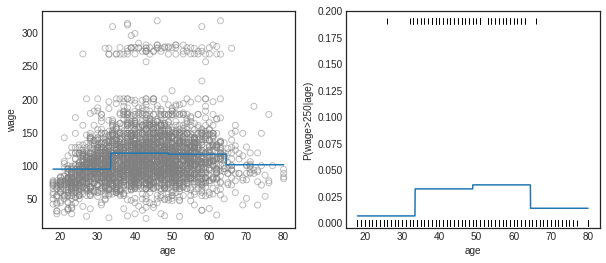

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df_step.age, df_step.wage, facecolors='None', edgecolors='grey', alpha=.5)

age_range = np.linspace(df_step.age.min(), df_step.age.max(), 1000)
age_range_dummies = pd.get_dummies(pd.cut(age_range, num_bins))
predictions = linear.predict(age_range_dummies)
ax1.plot(age_range, predictions)
ax1.set_xlabel('age')
ax1.set_ylabel('wage')

# Apply transforms to the data, and predict with the final estimator
predictions = pipe.predict_proba(age_range_dummies)[:, 1]
# probability of wage > 250 given age
ax2.plot(age_range, predictions)
ax2.set_ylim(ymin=-0.005, ymax=0.2)
# rug plot
ax2.plot(df_step.age, y*0.19, '|', color='k')
ax2.set_xlabel('age')
ax2.set_ylabel('P(wage>250|age)');

- Easy to work with. Creates a series of dummy variables
representing each group.
- Useful way of creating interactions that are easy to
interpret. For example, interaction effect of Year and Age:
I(Year < 2005)*Age; I(Year >= 2005)*Age
would allow for different linear functions in each age
category.
- In R: I(year < 2005) or cut(age; c(18; 25; 40; 65; 90))
- Choice of cutpoints or knots can be problematic. For
creating nonlinearities, smoother alternatives such as
splines are available.

### Piecewise Polynomials
- Instead of a single polynomial in $X$ over its whole domain, we can rather use different polynomials in regions defined by knots. E.g. (see figure)
$$
y_{i}=\left\{\begin{array}{ll}
\beta_{01}+\beta_{11} x_{i}+\beta_{21} x_{i}^{2}+\beta_{31} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i}<c \\
\beta_{02}+\beta_{12} x_{i}+\beta_{22} x_{i}^{2}+\beta_{32} x_{i}^{3}+\epsilon_{i} & \text { if } x_{i} \geq c
\end{array}\right.
$$
- Better to add constraints to the polynomials, e.g. continuity.
- Splines have the "maximum" amount of continuity.

In [ ]:
X = df_wage['age'].values.reshape(-1, 1)
y = df_wage['wage']
knots = np.percentile(X, [25, 50, 75])

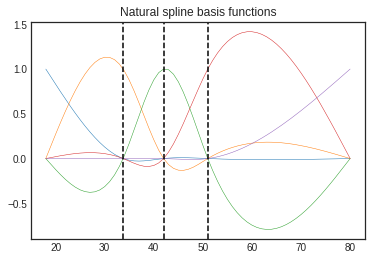

In [ ]:
spline_basis_plot = dmatrix("cr(x, knots=knots) -1", {"x": np.sort(X, axis=0), 'knots': knots}, return_type='dataframe')
plt.plot(np.sort(X, axis=0), spline_basis_plot.values, '-', linewidth=0.5)
for knot in knots:
    plt.axvline(knot, ls='--', color='k')
plt.title('Natural spline basis functions');

### Linear Splines 
A linear spline with knots at $\xi_{k}, k=1, \ldots, K$ is a piecewise linear polynomial continuous at each knot.
We can represent this model as
$$
y_{i}=\beta_{0}+\beta_{1} b_{1}\left(x_{i}\right)+\beta_{2} b_{2}\left(x_{i}\right)+\cdots+\beta_{K+3} b_{K+3}\left(x_{i}\right)+\epsilon_{i}
$$
where the $b_{k}$ are basis functions.
$$
\begin{aligned}
b_{1}\left(x_{i}\right) &=x_{i} \\
b_{k+1}\left(x_{i}\right) &=\left(x_{i}-\xi_{k}\right)_{+}, \quad k=1, \ldots, K
\end{aligned}
$$
Here the () $_{+}$ means positive part; i.e.
$$
\left(x_{i}-\xi_{k}\right)_{+}=\left\{\begin{aligned}
x_{i}-\xi_{k} & \text { if } x_{i}>\xi_{k} \\
0 & \text { otherwise }
\end{aligned}\right.
$$

### Cubic Splines
A cubic spline with knots at $\xi_{k}, k=1, \ldots, K$ is a piecewise cubic polynomial with continuous derivatives up to order 2 at each knot.
Again we can represent this model with truncated power basis functions
$$
\begin{aligned}
y_{i}=\beta_{0}+\beta_{1} b_{1}\left(x_{i}\right) &+\beta_{2} b_{2}\left(x_{i}\right)+\cdots+\beta_{K+3} b_{K+3}\left(x_{i}\right)+\epsilon_{i} \\
b_{1}\left(x_{i}\right) &=x_{i} \\
b_{2}\left(x_{i}\right) &=x_{i}^{2} \\
b_{3}\left(x_{i}\right) &=x_{i}^{3} \\
b_{k+3}\left(x_{i}\right) &=\left(x_{i}-\xi_{k}\right)_{+}^{3}, \quad k=1, \ldots, K
\end{aligned}
$$
where
$$
\left(x_{i}-\xi_{k}\right)_{+}^{3}=\left\{\begin{aligned}
\left(x_{i}-\xi_{k}\right)^{3} & \text { if } x_{i}>\xi_{k} \\
0 & \text { otherwise }
\end{aligned}\right.
$$

### Natural Cubic Splines
A natural cubic spline extrapolates linearly beyond the
boundary knots. This adds 4 = 2 * 2 extra constraints, and
allows us to put more internal knots for the same degrees of
freedom as a regular cubic spline.

### Generalized Additive Models
- Allows for flexible nonlinearities in several variables, but retains
- The additive structure of linear models.
$$
y_{i}=\beta_{0}+f_{1}\left(x_{i 1}\right)+f_{2}\left(x_{i 2}\right)+\cdots+f_{p}\left(x_{i p}\right)+\epsilon_{i}
$$

- Can fit a GAM simply using, e.g. natural splines:
lm(wage * ns(year; df = 5) + ns(age; df = 5) + education)
- Coefficients not that interesting; fitted functions are. The
previous plot was produced using plot.gam.
- Can mix terms | some linear, some nonlinear | and use
anova() to compare models.
- Can use smoothing splines or local regression as well:
gam(wage * s(year; df = 5) + lo(age; span = :5) + education)
- GAMs are additive, although low-order interactions can be
included in a natural way using, e.g. bivariate smoothers or
interactions of the form ns(age,df=5):ns(year,df=5).

In [ ]:
!pip install pygam

     |████████████████████████████████| 1.8MB 9.3MB/s 


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

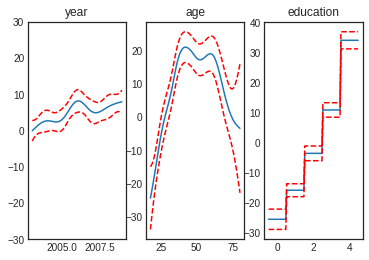

In [ ]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i]);


### GAMs for classification
$\log \left(\frac{p(X)}{1-p(X)}\right)=\beta_{0}+f_{1}\left(X_{1}\right)+f_{2}\left(X_{2}\right)+\cdots+f_{p}\left(X_{p}\right)$

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


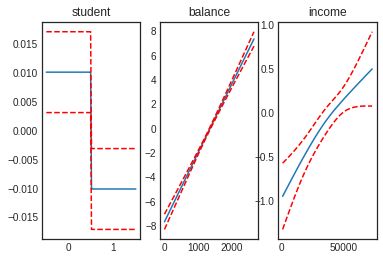

In [ ]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i])

### End of Chapter 7